In [1]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from utils import MyWarp, normalize

ROOT_DIR = Path("./data")
IMAGES_DIR = ROOT_DIR / "q3"
ANNOTATION_PATH = ROOT_DIR / "annotation" / "q3_annotation.npy"

BOOK_IMAGE_PATH = IMAGES_DIR / 'desk-normal.png'
DESK_IMAGE_PATH = IMAGES_DIR / 'desk-perspective.png'

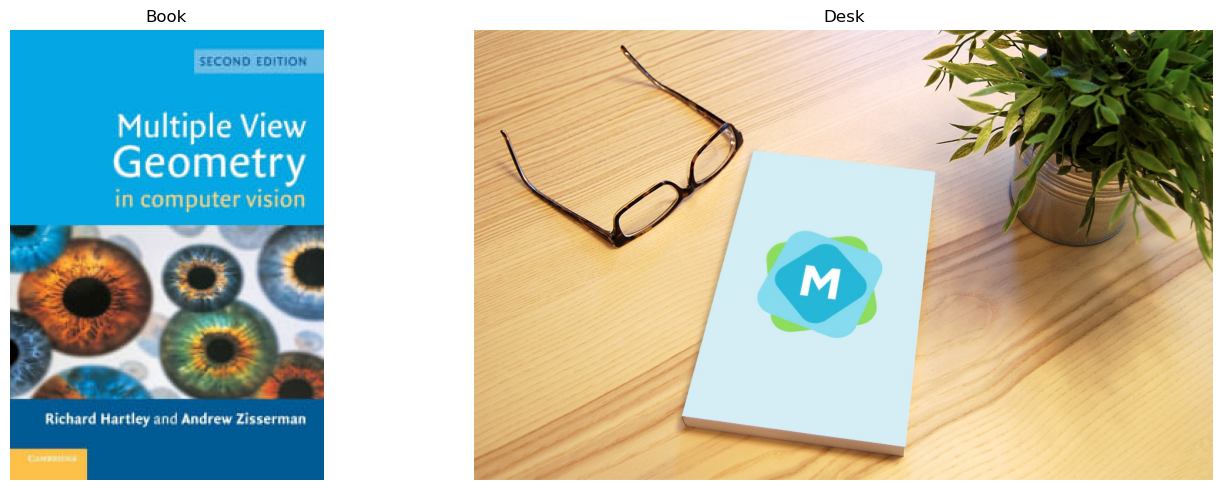

In [2]:
book_image = cv2.imread(BOOK_IMAGE_PATH)
desk_image = cv2.imread(DESK_IMAGE_PATH)

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.imshow(cv2.cvtColor(book_image, cv2.COLOR_BGR2RGB))
plt.title("Book")
plt.axis('off')

plt.subplot(122)
plt.imshow(cv2.cvtColor(desk_image, cv2.COLOR_BGR2RGB))
plt.title("Desk")
plt.axis('off')

plt.tight_layout()
plt.show()

In [3]:
annotations = np.load(ANNOTATION_PATH, allow_pickle=True).item()
annotations

{'desk-perspective': array([[533., 235.],
        [874., 275.],
        [818., 797.],
        [395., 738.]])}

In [4]:
h, w = book_image.shape[:2]

pts1 = np.array([
    [0, 0],        # top-left
    [w - 1, 0],    # top-right
    [w - 1, h - 1],# bottom-right
    [0, h - 1]     # bottom-left
], dtype=float)


pts2 = annotations['desk-perspective']

In [5]:
def normalize_points(points):
    """Normalize points for better numerical stability."""
    mean = np.mean(points, axis=0)
    std = np.std(points)
    scale = np.sqrt(2) / std
    T = np.array([
        [scale, 0, -scale * mean[0]],
        [0, scale, -scale * mean[1]],
        [0, 0, 1]
    ])
    points_h = np.hstack([points, np.ones((points.shape[0], 1))])
    normalized = (T @ points_h.T).T
    return normalized[:, :2], T


def compute_homography(pts1, pts2):
    """Compute homography H such that pts2 ~ H * pts1."""
    assert pts1.shape == pts2.shape
    n = pts1.shape[0]

    # Normalize
    pts1_n, T1 = normalize_points(pts1)
    pts2_n, T2 = normalize_points(pts2)

    A = []
    for i in range(n):
        x, y = pts1_n[i]
        xp, yp = pts2_n[i]
        A.append([-x, -y, -1, 0, 0, 0, x*xp, y*xp, xp])
        A.append([0, 0, 0, -x, -y, -1, x*yp, y*yp, yp])

    A = np.array(A)

    # Solve Ah = 0 using SVD
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1, :] / Vt[-1, -1]
    H_norm = h.reshape(3, 3)

    # Denormalize
    H = np.linalg.inv(T2) @ H_norm @ T1
    H /= H[2, 2]
    return H

In [6]:
H = compute_homography(pts1, pts2)

print("Homography Matrix:\n", H)

Homography Matrix:
 [[ 1.50011102e+00 -6.83550949e-01  5.33000000e+02]
 [ 1.64724127e-01  1.13822713e+00  2.35000000e+02]
 [-6.51791796e-05 -6.21406863e-04  1.00000000e+00]]


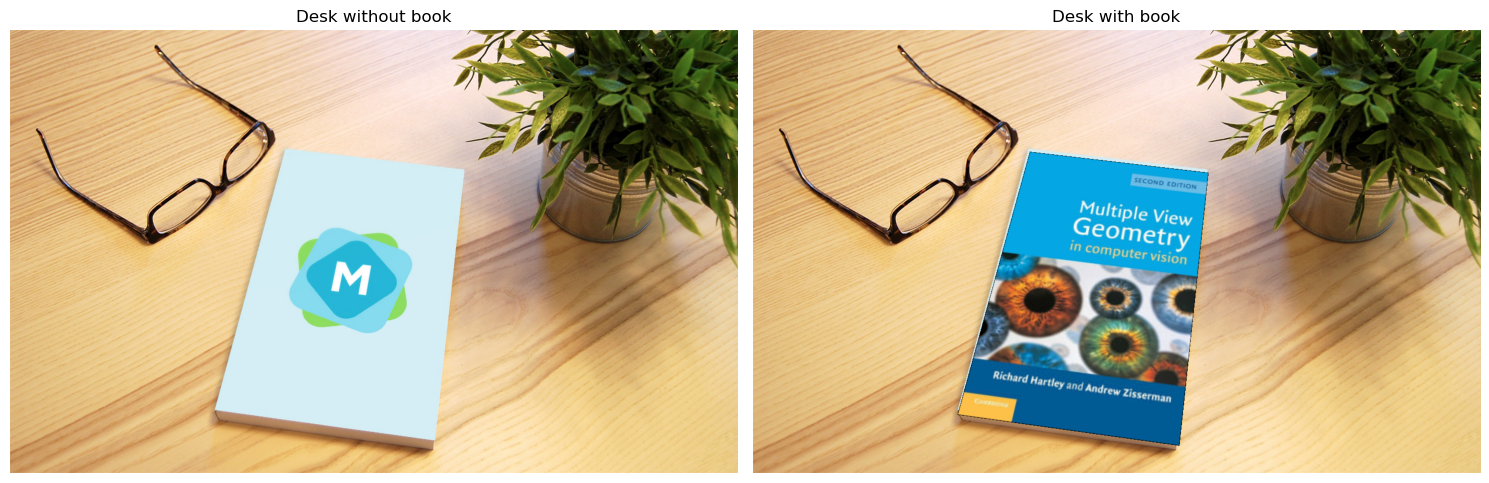

In [7]:
h2, w2 = desk_image.shape[:2]

# Warp image1 onto image2's plane
warped_img1 = cv2.warpPerspective(book_image, H, (w2, h2))

# Create a mask for nonzero pixels (where img1 contributed)
mask = cv2.warpPerspective(np.ones_like(book_image, dtype=np.uint8) * 255, H, (w2, h2))

# Use mask to combine the images
# Wherever warped_img1 has content, show it, otherwise keep image2
overlay = np.where(mask > 0, warped_img1, desk_image)


plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.imshow(cv2.cvtColor(desk_image, cv2.COLOR_BGR2RGB))
plt.title("Desk without book")
plt.axis('off')

plt.subplot(122)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Desk with book")
plt.axis('off')

plt.tight_layout()
plt.show()